# Titanic Survival Statistics Analysis

The first step in the analysis will be to load the data into a dataframe from the csv and take a quick look.

In [1]:
import pandas as pd
import numpy as np

passengers_orig = pd.read_csv('titanic_data.csv')
passengers_orig.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The csv file includes data about the passengers of the Titanic, along with their Class of cabin, Embarkement location and whether they survived. All the individuals in the list have Fare for their ticket and so I will assume that this data includes only the passengers and not the crew. As a result, the analysis below will be restricted to passengers only and not all people on board the Titanic. 

Looking at this data, I wonder what factors made a significant impact to the chances of survival? Factors that I would like to consider are 

1. Class of Cabin - Did the class of cabin make any different to an individual's chances of survival?

2. Gender - Did the genders have any signficant difference in their chances of survival? 

3. Age, that is, whether adult or child - Did the adults and children have any significant difference in their chances of survival?

Depending on the results for individual factors, I will also like to see how the results for a combination of different factors. For example, comparing survival rates of female child in Cabin Class 1 and male adults in Cabin Class 3.

The answer to these questions will address whether the survival rates were higher or lower for people with the above factors. The analysis would not provide an answer to the cause of the survival rate but would, instead, tell us which factor(s), or combinations of factors, experienced a higher or lower rate of survival in this accident.


Data Wrangling:
Before I start with the data analysis, I need to investigate the data in order to spot any inconsistencies or problems that will need to be cleaned up. I notice some of them from looking at the data and these are discussed below:

Inconsistency 1: The Cabin data is missing for several people.
There is no way to replace the missing data. I need to make sure that I do not use the Cabin information for the analysis. The good news is that we have the Pclass information for all the passengers and this can be used reliably for the analysis.

Inconsistency 2: The Age data is missing for several passengers.
In order to answer the question, I need to know whether the passenger is an adult or a child. I will assume that an individual of the age of 18 or greater is an adult. However, lack of data for age could be problematic especially if it affects a large part of the dataset. First, I try to understand how much of the data has this issue.

In [2]:
passengers_len = len(passengers_orig['Age'])
passengers_age_len = passengers_orig['Age'].count()
passengers_age_missing = passengers_len - passengers_age_len

print ("Total passengers: {}".format(passengers_len))
print ("Passengers with Age data available: {}".format(passengers_age_len))
print ("Passengers with missing Age data: {}".format(passengers_age_missing))
print ("Passengers with missing Age data (in %): {:.2f}%".format((float(passengers_age_missing)/passengers_len)*100.0))

Total passengers: 891
Passengers with Age data available: 714
Passengers with missing Age data: 177
Passengers with missing Age data (in %): 19.87%


This shows that almost 20% of the data has the Age information missing and this information is not possible to replace. However, our concern is whether an individual is an adult or a child and we could potentially use information from the rest of the dataset to make some assessment. I have come up with the below hypothesis for this purpose:
1. Mr and Mrs in the name suggests an adult
2. Master in the name suggests a child
3. Miss in the name is not conclusive to decide adult or child.

Each of the above needs to be tested against the dataset where we know the age of the passengers to prove their correctness and then on the basis of the results, apply them to the dataset where we don't know the age of the passengers. I also need to test if there are any other titles in the name for those with missing Age and whether I can assign them to any of the 3 hypothesis.

I will need to filter out the passengers with available age data and another with age data not available. Then I need to write a function that takes the name as input and returns the title.

In [3]:
passengers_age_known = passengers_orig[ np.isnan(passengers_orig['Age']) == False].copy()
passengers_age_known.head()

# passengers_age_known now contains only the passenger data with a valid Age value.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
passengers_age_unknown = passengers_orig[ np.isnan(passengers_orig['Age']) == True].copy()
passengers_age_unknown.head()

# passengers_age_unknown now contains only the passenger data with an invalid Age value.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [5]:
# Function to retrieve the title of a person from their name

def get_title(passenger):
    passenger_name = passenger['Name']
    names = passenger_name.split(', ')
    title = names[1].split('.')
    return title[0]

# Testing the above function
for i in range(0,5):
    print ("The name is: ", passengers_age_known.loc[i,'Name'])
    print ("The title is: ", get_title(passengers_age_known.loc[i]))


The name is:  Braund, Mr. Owen Harris
The title is:  Mr
The name is:  Cumings, Mrs. John Bradley (Florence Briggs Thayer)
The title is:  Mrs
The name is:  Heikkinen, Miss. Laina
The title is:  Miss
The name is:  Futrelle, Mrs. Jacques Heath (Lily May Peel)
The title is:  Mrs
The name is:  Allen, Mr. William Henry
The title is:  Mr


I will create 3 list of titles, one for each hypothesis. Then I will run the get_title() function to retrieve the title for each name in passenger_age_unknown. I will compare this list of titles with the 3 lists to identify if any title not covered by the 3 lists.

In [6]:
titles_hypothesis1 = ['Mr', 'Mrs']
titles_hypothesis2 = ['Master']
titles_hypothesis3 = ['Miss']

titles_hypothesis_all = titles_hypothesis1 + titles_hypothesis2 + titles_hypothesis3

passengers_age_unknown['Title'] = passengers_age_unknown.apply(get_title, axis=1)

passengers_age_unknown.groupby('Title').indices.keys()


dict_keys(['Dr', 'Master', 'Miss', 'Mr', 'Mrs'])

In [7]:
titles_hypothesis1 += ['Dr']

I will now test the 3 hypothesis.

I will create a function, age_hypothesis_test, that will take a row of passengers_age_known dataframe and return the title along with a new column called Age_Compare. The Age_Compare column will have boolean values and will be True when the hypothesis 1 and 2 are found to be correct for that passenger. If they are found to be not correct or if the Title is 'Miss', then the column shall contain False. We will store these 2 columns along with the Name and Age from the dataframe in a new dataframe called age_hypothesis_check. We will assume that an adult has age greater than or equal to 18.

I identify that there is another title in the list, 'Dr', that I had not considered in my hypothesis. Since this title is associated with education qualification and profession, I will assign it to the hypothesis 1 (adult). The revised hypothesis are now:

1. Dr, Mr and Mrs in the name suggests an adult
2. Master in the name suggests a child
3. Miss in the name is not conclusive to decide adult or child.

I will update the title list for hypothesis 1.

In [8]:
# Creating function age_hypothesis_test

def age_hypothesis_test(passenger):
    title = get_title(passenger)
    name = passenger['Name']
    age = passenger['Age']
    age_compare = False     # Initialised as False

    # Hypothesis 1 test
    if title in titles_hypothesis1:
        if age >= 18:
            age_compare = True
    
    # Hypothesis 2 test
    if title in titles_hypothesis2:
        if age < 18:
            age_compare = True
    
    return age_compare
    

In [9]:
passengers_age_known['Title'] = passengers_age_known.apply(get_title, axis=1)
passengers_age_known['Age_Compare'] = passengers_age_known.apply(age_hypothesis_test, axis=1)

passengers_age_known.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Compare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,True


In [10]:
hypothesis1 = passengers_age_known[passengers_age_known['Title'].isin(titles_hypothesis1)]

hypothesis1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Compare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,True
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,True


In [11]:
hypothesis2 = passengers_age_known[passengers_age_known['Title'].isin(titles_hypothesis2)]

hypothesis2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Compare
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,True
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q,Master,True
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S,Master,True
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,Master,True
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,Master,True


In [12]:
hypothesis3 = passengers_age_known[passengers_age_known['Title'].isin(titles_hypothesis3)]

hypothesis3.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Compare
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,Miss,False
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,Miss,False
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,Miss,False
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,Miss,False


Now we have necessary data to test each hypothesis under their respective dataframes, hypothesis1, hypothesis2 and hypothesis3 respectively. 
Hypothesis 1 and 2 will be tested by identifying and analysing any False value in Age_Compare.
Hypothesis 3 includes only 1 title. This hypothesis will be tested by comparing the count of passengers that are adults with those that are not. 

In [13]:
# Hypothesis 1 testing

error_rate = {}

print ("Hypothesis 1 testing")
for name, group in hypothesis1.groupby('Title'):
    total_count = len(group)
    fail_count = len(group[group['Age_Compare'] == False])
    error_rate[name] = (float(fail_count)/total_count) * 100.0
    print ("\nName: ", name)
    print ("Total Count: {}".format(total_count))
    print ("Failed: {}".format(fail_count))
    print ("Error Rate: {:.2f}".format(error_rate[name]))
    
    
# Hypothesis 2 testing

print ("\n\nHypothesis 2 testing")
for name, group in hypothesis2.groupby('Title'):
    total_count = len(group)
    fail_count = len(group[group['Age_Compare'] == False])
    error_rate[name] = (float(fail_count)/total_count) * 100.0
    print ("\nName: ", name)
    print ("Total Count: {}".format(total_count))
    print ("Failed: {}".format(fail_count))
    print ("Error Rate: {:.2f}".format(error_rate[name]))

# Hypothesis 3 testing

print ("\n\nHypothesis 3 testing")
for name, group in hypothesis3.groupby('Title'):
    total_count = len(group)
    adult_count = len(group[group['Age'] >= 18])
    adult_rate = (float(adult_count)/total_count) * 100.0
    child_count = len(group[group['Age'] < 18])
    child_rate = (float(child_count)/total_count) * 100.0
    print ("\nName: ", name)
    print ("Total Count: {}".format(total_count))
    print ("Adults: {}".format(adult_count))
    print ("Adult Rate: {:.2f}".format(adult_rate))
    print ("Children: {}".format(child_count))
    print ("Child Rate: {:.2f}".format(child_rate))

Hypothesis 1 testing

Name:  Dr
Total Count: 6
Failed: 0
Error Rate: 0.00

Name:  Mr
Total Count: 398
Failed: 22
Error Rate: 5.53

Name:  Mrs
Total Count: 108
Failed: 4
Error Rate: 3.70


Hypothesis 2 testing

Name:  Master
Total Count: 36
Failed: 0
Error Rate: 0.00


Hypothesis 3 testing

Name:  Miss
Total Count: 146
Adults: 95
Adult Rate: 65.07
Children: 51
Child Rate: 34.93


The testing shows that we have 0% error rate for titles of Dr and Master. It also shows that the title of Miss is used by both adults and children in significant proportions. As a result, we can not determine whether a passenger with Miss as title, to be either an adult or a child. 
This implies that the Hypothesis 2 and 3 has been successful and they can be applied to the original dataset.
In Hypothesis 1 testing, I found that titles of Mr and Mrs have non-zero error rates. These error rates are small, 5.53% for Mr and 3.7% for Mrs. Though, this can not be compared to a confidence interval due to lack of statistical inferences, the lower error rates should allow us to generate a much bigger benefit of better analysis results. We should test the last statement by checking how much error would this generate if we applied the data from 'Mr' and 'Mrs' titles with unknown ages to the original dataset.

In [14]:
# Testing the impact of errors by correcting for Mr and Mrs.

count_age_known = len(passengers_age_known)

# Getting count of passengers with a specific title and known age
def get_count_known_age(title):
    return len(passengers_age_known[passengers_age_known['Title'] == title['Title']])

# Getting count of passengers with a specific title and unknown age
def get_count_unknown_age(title):
    return len(passengers_age_unknown[passengers_age_unknown['Title'] == title['Title']])

# Getting error rate for a specific title
def get_error_rate(title):
    return error_rate[title['Title']]

# Getting incremental increase in passengers by including the unknowns in this title
def get_incr(title):
    return (float(title['Unknown_Age'])/count_age_known)*100.0

# Getting number of errors introduced by including the unknowns in this title
# assuming error rate from hypothesis testing can be used
def get_error_num(title):
    return (title['Error_Rate'] * 0.01 * title['Unknown_Age'])


# Getting % error rate with respect to the entire population on including the unknowns in this title
# assuming error rate from hypothesis testing can be used
def get_incr_error_rate(title):
    return (title['Error_Rate'] * 0.01 * title['Unknown_Age'])/(count_age_known + title['Unknown_Age']) * 100.0



titles = pd.DataFrame([['Mr'],['Mrs']], columns = ['Title'])
titles['Known_Age'] = titles.apply(get_count_known_age, axis = 1)
titles['Unknown_Age'] = titles.apply(get_count_unknown_age, axis = 1)
titles['Error_Rate'] = titles.apply(get_error_rate, axis = 1)
titles['Incr_Passengers_Rate'] = titles.apply(get_incr, axis = 1)
titles['Incr_Error_Num'] = titles.apply(get_error_num, axis = 1)
titles['Incr_Error_Rate'] = titles.apply(get_incr_error_rate, axis = 1)
                                                         
titles.head()

,Title,Known_Age,Unknown_Age,Error_Rate,Incr_Passengers_Rate,Incr_Error_Num,Incr_Error_Rate
0,Mr,398,119,5.527638,16.666667,6.577889,0.789663
1,Mrs,108,17,3.703704,2.380952,0.629630,0.086133


In [15]:
# Calculating similar stats for applying the methodology for all rows in titles

total_incr_rate = (float(titles['Unknown_Age'].sum())/count_age_known) * 100.0
total_incr_error_rate = titles['Incr_Error_Num'].sum() / (count_age_known + titles['Unknown_Age'].sum()) * 100.0

print ("Percentage increase in number of passengers for analysis: {:.2f}%".format(total_incr_rate))
print ("Total Error Rate introduced in the combined passengers list: {:.2f}%".format(total_incr_error_rate))


Percentage increase in number of passengers for analysis: 19.05%
Total Error Rate introduced in the combined passengers list: 0.85%


The above testing shows:
By including the passengers with 'Mr' title and unknown age data to the list of passengers with known age, we increase the number of available passengers for analysis by 16.67% with an error rate of 0.79%.
By including the passengers with 'Mrs' title and unknown age data to the list of passengers with known age, we increase the number of available passengers for analysis by 2.38% with an error rate of 0.09%.
By including the passengers with 'Mr' and 'Mrs' titles and unknown age data to the list of passengers with known age, we increase the number of available passengers for analysis by 19.05% with an error rate of 0.85%.

The error rate introduced by including 'Mr' and 'Mrs' titles, individually and combined, is very low compared to the percentage increase in the passenger list now available for anwering the questions. Hence, I conclude that Hypothesis 1 testing is also successful. 

Accepting all the 3 hypothesis now allows us to expand the passenger data set. 

The below code will make the necessary changes to the passenger_orig data by adding 1 column for Title and 2 more columns, IsAdult and IsChild. Both columns will store boolean values. IsAdult is True if the passenger is an adult, else False. IsChild is True if the passenger is a child, else False. Adult means the age should be greater than or equal to 18 years. Where age is not known, the hypothesis 1, 2 and 3 will be applied. As a result, passengers with 'Miss' in the title and no known age, will have False for both columns while all other passengers are expected to have one column as True.
As we see below, the test the updated dataframe to ensure that number of passengers with both IsAdult and IsChild as True is zero. We can also see that 36 passengers have "Miss" as their title and we are not sure if they are Adult or Child which is 4.04% of total passenger number, the total passenger number being 891 as calculated earlier.

In [16]:
# Function to decide IsAdult flag
def get_IsAdult(passenger):
    if np.isnan(passenger['Age']):
        return run_hypothesis1(passenger)
    else:
        return (passenger['Age'] >= 18)
    
# Run the hypothesis1
def run_hypothesis1(passenger):
    return (passenger['Title'] in titles_hypothesis1)

# Function to decide IsChild flag
def get_IsChild(passenger):
    if np.isnan(passenger['Age']):
        return run_hypothesis2(passenger)
    else:
        return (passenger['Age'] < 18)
    
# Run the hypothesis2
def run_hypothesis2(passenger):
    return (passenger['Title'] in titles_hypothesis2)


# Add title to passenger_orig
passengers_orig['Title'] = passengers_orig.apply(get_title, axis = 1)

# Adding IsAdult and IsChild flags
passengers_orig['IsAdult'] = passengers_orig.apply(get_IsAdult, axis = 1)
passengers_orig['IsChild'] = passengers_orig.apply(get_IsChild, axis = 1)

passengers_orig.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsAdult,IsChild
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,True,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,True,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,True,False


In [17]:
# Testing for any errorenous case of both IsAdult and IsChild being True
passengers_orig[(passengers_orig['IsAdult'] == True) & (passengers_orig['IsChild'] == True)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsAdult,IsChild


In [18]:
passengers_orig[(passengers_orig['IsAdult'] == False) & (passengers_orig['IsChild'] == False)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsAdult,IsChild
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss,False,False
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,Miss,False,False
47,48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,NaN,Q,Miss,False,False
82,83,1,3,"McDermott, Miss. Brigdet Delia",female,NaN,0,0,330932,7.7875,NaN,Q,Miss,False,False
109,110,1,3,"Moran, Miss. Bertha",female,NaN,1,0,371110,24.1500,NaN,Q,Miss,False,False


In [19]:
len(passengers_orig[(passengers_orig['IsAdult'] == False) & (passengers_orig['IsChild'] == False)])

36

Inconsistency 3: From a quick look at the data, it seems like there may be some families with large number of people on board but not enough with same surname show up on the list. The data gives us SibSp and Parch that I can use, along with the surname, to identify the name and size of the family. I can count the number of passengers with the same surname to compare with the size and find out if there are any missing passengers on the list.

This method has potential for generating false positives as it possible that someone in the family doesn't share the same surname (daughter sharing husband's surname) or multiple families with same surname on the ship. However, still I would like to test this idea to check if I can find any meaningful answer.

On further inspection of the data, I find that the female passengers with 'Mrs' title have another name within brackets. This another name looks to be their maiden name and contains their family surname. The name after 'Mrs' looks to be the husband's name. For example - "Cumings, Mrs. John Bradley (Florence Briggs Thayer)". I can use this information to identify the maiden surname of the married females and attempt to reduce the false positives. For each individual, the family size remains the sum of SibSp, Parch and 1 (1 to include themselves) and this can be compared against the sum of the number of passengers with same surname, number of passengers with same maiden surname (if different from surname) and 1 (1 to include themselves). The difference of the comparison will be the number of missing family members. This difference will be floored to zero as it can go negative due to the presence of several passengers with same surname but not of same family. 

The quality of the analysis can be improved by doing the analysis separately for each Pclass as it can be assumed that all members of same family are in the same Pclass.

I will create a copy of the passenger_orig dataframe so that I can add new columns for testing this inconsistency while keeping the original dataframe data secure. 

In [20]:
passengers_copy = passengers_orig.copy()

# Function to get the surname
def get_surname(passenger):
    passenger_name = passenger['Name']
    names = passenger_name.split(', ')
    return names[0]

passengers_copy['Surname'] = passengers_copy.apply(get_surname, axis = 1)

# Function to get family size from the passenger's data
def get_family_size(passenger):
    return passenger['SibSp'] + passenger['Parch'] + 1

passengers_copy['FamilySize'] = passengers_copy.apply(get_family_size, axis = 1)

# Function to get the maiden surname
def get_maiden_surname(passenger):
    name = passenger['Name']
    if passenger['Title'] == 'Mrs':
        start_index = name.find('(')
        end_index = name.find(')')
        maiden_name = name[start_index + 1 : end_index]
        names_split = maiden_name.split(', ')
        return names_split[0]
    else:
        return passenger['Surname']
    
passengers_copy['Maiden_Surname'] = passengers_copy.apply(get_maiden_surname, axis = 1)
    
passengers_copy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsAdult,IsChild,Surname,FamilySize,Maiden_Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,True,False,Braund,2,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,False,Cumings,2,Florence Briggs Thayer
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,True,False,Heikkinen,1,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True,False,Futrelle,2,Lily May Peel
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,True,False,Allen,1,Allen


In [21]:
# Function to return count of the rows in a group from a grouped data
def get_count(group):
    return len(group)

# Counting the passengers with same surname
surname_group = passengers_copy.groupby('Surname')
surname_count = surname_group.apply(get_count)

# Counting the passengers with same maiden surname
maiden_surname_group = passengers_copy.groupby('Maiden_Surname')
maiden_surname_count = maiden_surname_group.apply(get_count)

# Counting the passengers with same surname and Pclass
pclass_surname_group = passengers_copy.groupby(['Pclass', 'Surname'])
pclass_surname_count = pclass_surname_group.apply(get_count)


# Counting the passengers with same maiden surname and Pclass
pclass_maiden_surname_group = passengers_copy.groupby(['Pclass', 'Maiden_Surname'])
pclass_maiden_surname_count = pclass_maiden_surname_group.apply(get_count)


In [22]:
# FamilySize check for each individual

# Function to check FamilySize for each individual and return number of missing members
def family_check(passenger):
    surname = passenger['Surname']
    maiden_surname = passenger['Maiden_Surname']
    if surname == maiden_surname:
        family_count = surname_count.loc[surname] + 1
    else:
        family_count = surname_count.loc[surname] + maiden_surname_count.loc[maiden_surname] + 1
    missing_count = max(0,passenger['FamilySize'] - family_count)
    return missing_count

# Function to check FamilySize for each individual and return number of missing members, taking Pclass into account
def pclass_family_check(passenger):
    surname = passenger['Surname']
    maiden_surname = passenger['Maiden_Surname']
    pclass = passenger['Pclass']
    if surname == maiden_surname:
        family_count = pclass_surname_count.loc[pclass, surname] + 1
    else:
        family_count = pclass_surname_count.loc[pclass, surname] + \
        pclass_maiden_surname_count.loc[pclass, maiden_surname] + 1
    missing_count = max(0,passenger['FamilySize'] - family_count)
    return missing_count

passengers_copy['Fam_Missing'] = passengers_copy.apply(family_check, axis = 1)
passengers_copy['Pclass_Fam_Missing'] = passengers_copy.apply(pclass_family_check, axis = 1)

passengers_copy.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsAdult,IsChild,Surname,FamilySize,Maiden_Surname,Fam_Missing,Pclass_Fam_Missing
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,True,False,Braund,2,Braund,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,False,Cumings,2,Florence Briggs Thayer,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,True,False,Heikkinen,1,Heikkinen,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True,False,Futrelle,2,Lily May Peel,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,True,False,Allen,1,Allen,0,0


In [23]:
passengers_copy[passengers_copy['Fam_Missing'] > 0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsAdult,IsChild,Surname,FamilySize,Maiden_Surname,Fam_Missing,Pclass_Fam_Missing
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S,Mrs,True,False,Asplund,7,Selma Augusta Emilia Johansson,1,1
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,Mr,True,False,Fortune,6,Fortune,1,1
48,49,0,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C,Mr,True,False,Samaan,3,Samaan,1,1
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,Master,False,True,Goodwin,8,Goodwin,1,1
69,70,0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S,Mr,True,False,Kink,3,Kink,1,1


In [24]:
passengers_copy[passengers_copy['Fam_Missing'] != passengers_copy['Pclass_Fam_Missing']].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsAdult,IsChild,Surname,FamilySize,Maiden_Surname,Fam_Missing,Pclass_Fam_Missing
565,566,0,3,"Davies, Mr. Alfred J",male,24.0,2,0,A/4 48871,24.15,NaN,S,Mr,True,False,Davies,3,Davies,0,1


In [25]:
print (len(passengers_copy[passengers_copy['Pclass_Fam_Missing'] > 0]))

48


In the above dataset, we find that there is one passenger who has a different value for missing family members when the Pclass is taken into account. On inspecting the data, I find that there are 2 more passengers with surname "Davies" who are in Pclass 2 who would be counted as being part of this passenger's family if Pclass is not taken into account. One of those 2 passengers has zero other family members on board. This proves that including Pclass as another criteria has allowed us to identify more sets of missing family members that would have otherwise got missed.

We also understand that 48 passengers have at least 1 family member missing in the original csv data file.

Next step is to get an estimate for the minimum number of missing passengers from the list. We can only attempt to calculate the minimum value and not a good approximate value because of these reasons:
1. We are unable to check if an entire family is missing
2. Our analysis under-estimates the number of missing passengers as it relies on surname and maiden surname. It is possible that people with same surname but belong to different families have been incorrectly assumed to be of same family in this analysis
3. The data gives a combined value for Parents and Children and another combined value for Spouse and siblings. As a result, I am unable to create a reliable family tree structure and precisely count the missing people. An illustration of this is provided in the next paragraph.

I will get an estimate by grouping the passengers_copy data by Pclass and Maiden_Surname and then checking for the maximum value for each group. I use Maiden_Surname instead of Surname as I wish to avoid double counting the number if a married woman has any members missing from her family. For example, if a married woman has 3 siblings but 1 is missing, then I wish to avoid counting that missing sibling while checking for the woman's Surname and then the sibilings' Surname. If the woman's husband is missing too, then I will still get the correct value by choosing Maiden_Surname because she will be expected to have 1 more missing family compared to her siblings and I am taking the maximum value here. However, if one of those siblings is another married woman with also a missing husband, then this method will be counting only 1 missing husband and so I will be under-estimating the total missing value. This is another reason why I can calculate a minimum value only for the missing number of passengers.

In [26]:
# Counting minimum number of missing passengers

# Function to calculate max of Pclass_Fam_Missing for a group
def get_min_missing(group):
    return max(group['Pclass_Fam_Missing'])

passenger_group = passengers_copy.groupby(['Pclass', 'Maiden_Surname'])

passengers_missing = passenger_group.apply(get_min_missing)

pclass_passengers_missing = passengers_missing.groupby(level = 'Pclass').sum()

total_passengers_missing = pclass_passengers_missing.sum()

print ("Passengers missing per Pclass: \n", pclass_passengers_missing)
print ("\nTotal Passengers Missing from dataset: ", total_passengers_missing)

Passengers missing per Pclass: 
 Pclass
1     9
2     9
3    15
dtype: int64

Total Passengers Missing from dataset:  33


In [27]:
pclass_size = passengers_copy.groupby('Pclass').apply(get_count)

actual_pclass_size = pclass_passengers_missing + pclass_size

print ('Number of passengers per Pclass as per original data is\n',pclass_size)

missing_rate = ((pclass_passengers_missing)/actual_pclass_size) * 100.0

print ('\n\nPercentage of minimum missing passengers per Pclass: \n', missing_rate)

missing_rate_total = (float(total_passengers_missing)/actual_pclass_size.sum()) * 100.0

print ('\n\nPercentage of minimum missing passengers across the entire ship is {:.2f}%'.format(missing_rate_total))

Number of passengers per Pclass as per original data is
 Pclass
1    216
2    184
3    491
dtype: int64


Percentage of minimum missing passengers per Pclass: 
 Pclass
1    4.000000
2    4.663212
3    2.964427
dtype: float64


Percentage of minimum missing passengers across the entire ship is 3.57%


In total, there are a minimum of 33 passengers missing from the Titanic data which is 3.57% of the passenger data available. The percentage of minimum missing passengers per Pclass has been calculated above. It is difficult to estimate the actual percentage of missing passengers due to reasons mentioned earlier. Though, the minimum percentage levels are fairly low, the actual percentage levels could be much higher and hence, significant. This will introduce uncertainty in providing conclusive answers to the questions and should be considered while making any conclusions. 

I have looked into 3 different inconsistencies and highlighted the limitations. Next I will move to the Exploration Phase.

Exploration Phase:

In this phase, I will explore the data stored in the updated passengers data (passengers_orig) to answer the questions I had phrased earlier. I will repeat those questions here:
What factors made a significant impact to the chances of survival? Factors that I would like to consider are
1. Class of Cabin
2. Gender
3. Age, that is, whether adult or child. Gender and Age can be analysed either within each Class of Cabin or for the overall ship.

For each factor, I would like to see the percentage of people that survived and compare that to the percentage of people that survived across the entire ship. 
First, I will calculate the percentage of people that survived across the entire ship and then proceed for each factor

In [28]:
# Calculate the percentage of people that survived on the ship.

count_passengers = len(passengers_orig)
count_passengers_survived = len(passengers_orig[passengers_orig['Survived'] == 1])

percentage_passengers_survived = (float(count_passengers_survived)/count_passengers) * 100.0

print ("Total passengers: ", count_passengers)
print ("Total passengers survived: ", count_passengers_survived)
print ("Percentage of passengers that survived: {:.2f}%".format(percentage_passengers_survived))

Total passengers:  891
Total passengers survived:  342
Percentage of passengers that survived: 38.38%


In [29]:
# Running survival numbers for each factor

# function to calculate length of a group
def get_group_length(group):
    return len(group)

# function to calculate survival count of a group
def get_group_survival(group):
    return len(group[group['Survived'] == 1])


# function to calculate percentage survival for each factor
def get_survival_percentage(factor, passengers):
    grouped = passengers.groupby(factor)
    grouped_count = grouped.apply(get_group_length)
    grouped_survival = grouped.apply(get_group_survival)
    grouped_surv_perc = (grouped_survival / grouped_count) * 100.0
    return grouped_surv_perc

# Survival percentage for Class of Cabin
pclass_surv = get_survival_percentage('Pclass', passengers_orig)

# Survival percentage for Gender
gender_surv = get_survival_percentage('Sex', passengers_orig)

# Survival percentage for Adults
adults_surv = get_survival_percentage('IsAdult', passengers_orig)

# Survival percentage for Children
child_surv = get_survival_percentage('IsChild', passengers_orig)

age_surv = pd.Series([adults_surv.loc[True], child_surv.loc[True]], index = ['Adult', 'Child'])
age_surv.index.name = 'Age'

print ("Survival rate by class: \n", pclass_surv)
print ("\nSurvival rate by gender: \n", gender_surv)
print ("\nSurvival rate by adults: \n", adults_surv)
print ("\nSurvival rate by children: \n", child_surv)
print ("\nSurvival rate by Age: \n", age_surv)



Survival rate by class: 
 Pclass
1    62.962963
2    47.282609
3    24.236253
dtype: float64

Survival rate by gender: 
 Sex
female    74.203822
male      18.890815
dtype: float64

Survival rate by adults: 
 IsAdult
False    55.555556
True     34.823848
dtype: float64

Survival rate by children: 
 IsChild
False    36.046512
True     53.846154
dtype: float64

Survival rate by Age: 
 Age
Adult    34.823848
Child    53.846154
dtype: float64


In [30]:
pclass_gender_surv = get_survival_percentage(['Pclass','Sex'], passengers_orig)
print ("\nSurvival rate by pclass and gender: \n", pclass_gender_surv)


Survival rate by pclass and gender: 
 Pclass  Sex   
1       female    96.808511
        male      36.885246
2       female    92.105263
        male      15.740741
3       female    50.000000
        male      13.544669
dtype: float64


In [31]:
pclass_child_surv = get_survival_percentage(['Pclass','IsChild'], passengers_orig)
print ("\nSurvival rate by pclass and IsChild: \n", pclass_child_surv)

pclass_adult_surv = get_survival_percentage(['Pclass','IsAdult'], passengers_orig)
print ("\nSurvival rate by pclass and IsAdult: \n", pclass_adult_surv)


Survival rate by pclass and IsChild: 
 Pclass  IsChild
1       False      61.274510
        True       91.666667
2       False      40.993789
        True       91.304348
3       False      21.515892
        True       37.804878
dtype: float64

Survival rate by pclass and IsAdult: 
 Pclass  IsAdult
1       False      92.307692
        True       61.083744
2       False      92.000000
        True       40.251572
3       False      43.478261
        True       18.351064
dtype: float64


In [32]:
# Merging the pclass_child_surv and pclass_adult_surv by taking only the True index values

pclass_child_true = pclass_child_surv.loc[:,True]
pclass_adult_true = pclass_adult_surv.loc[:,True]

pclass_child_true_len = len(pclass_child_true)
pclass_adult_true_len = len(pclass_adult_true)


pclass_age_surv = pd.DataFrame({
        'Pclass': pclass_child_true.index.tolist() + pclass_adult_true.index.tolist(),
        'Age_Type': ['Child']*pclass_child_true_len + ['Adult']*pclass_adult_true_len,
        'Survival_Percentage': pclass_child_true.tolist() + pclass_adult_true.tolist()
    })

print ("\nSurvival rate by pclass and Age Type: \n")
pclass_age_surv.head(10)


Survival rate by pclass and Age Type: 



,Pclass,Age_Type,Survival_Percentage
0,1,Child,91.666667
1,2,Child,91.304348
2,3,Child,37.804878
3,1,Adult,61.083744
4,2,Adult,40.251572
5,3,Adult,18.351064


I now have the necessary data to proceed and create the plots to get a visual representation of the results. I will be creating the below plots to help me answer the questions:

1. Class of cabin - I will draw a vertical bar chart on pclass_surv to compare the survival rate between different cabin classes. In addition, I will draw a horizontal line to represent the average survival rate across the entire ship.

2. Gender - I will draw a similar chart as above for gender_surv, along with the horizontal line

3. Age - I will draw a similar chart as above for age_surv, along with the horizontal line

4. Class of cabin and Gender - I will draw a vertical bar chart on pclass_gender_surv to compare the survival rate between the sexes in each cabin class. This will allow me to compare how male vs female survival rates for different cabin classes as well as compare the survival rate amongst each sex across the cabin classes. I will also draw the horizontal line to see how each bar compares with the average survival rate across the entire ship.

5. Class of cabin and Age - I will draw a similar vertical bar chart on pclass_age_surv, along with the horizontal line.

Once I have the above charts, I will decide whether further analysis is needed.

In [33]:
pclass_average = pd.DataFrame({
        pclass_surv.index.name : pclass_surv.index.tolist(),
        'Average_Percentage': [percentage_passengers_survived]*len(pclass_surv),
        'Percentage Survived': pclass_surv.values
        })

                            
print (pclass_average)

   Pclass  Average_Percentage  Percentage Survived
0       1           38.383838            62.962963
1       2           38.383838            47.282609
2       3           38.383838            24.236253


Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

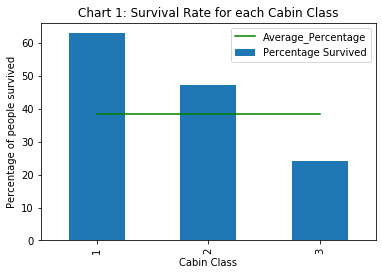

<Figure size 432x288 with 0 Axes>

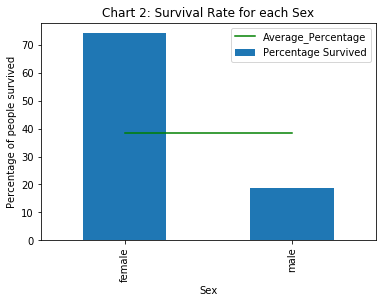

<Figure size 432x288 with 0 Axes>

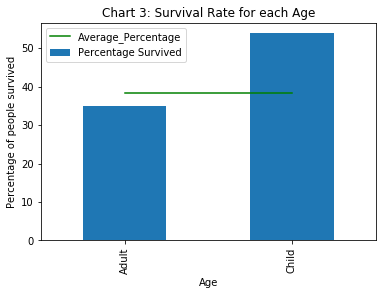

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline


# Function to plot bar charts with line for average

def plot_surv(surv, xlabel, plot_count):
    surv_df = pd.DataFrame({
        surv.index.name : surv.index.tolist(),
        'Average_Percentage': [percentage_passengers_survived]*len(surv),
        'Percentage Survived': surv.values
        })
    plt.figure()
    ax = surv_df.plot(y = 'Average_Percentage', kind = 'line', color = 'g')
    surv_df.plot(x = surv.index.name, y = 'Percentage Survived', kind = 'bar', ax = ax)
    plt.xlabel(xlabel)
    plt.ylabel('Percentage of people survived')
    plt.title ('Chart %s: Survival Rate for each %s' % (plot_count, xlabel))
    return

plot_count = 1

plot_surv(pclass_surv, 'Cabin Class', plot_count)

plot_count += 1

plot_surv(gender_surv, gender_surv.index.name, plot_count)

plot_count += 1

plot_surv(age_surv, age_surv.index.name, plot_count)


From chart 1, I notice that the percentage of survivors is highest in 1st Class, relatively lower in 2nd Class and lowest in 3rd Class. The percentage for 1st Class and 2nd Class is higher than the average for the entire ship.

Chart 2 shows that females had a much higher rate of survival compared to males. While the survival rate for females is much higher to the ship's average, the survival rate for males is much lower than the ship's average

Chart 3 shows that children had a higher rate of survival than adults. Morevoer, children had a survival rate higher than the ship's average but adults had a lower survival rate than the ship's average


Next, I will progress to developing charts 4 and 5 in order to see how the survival rate compares between genders and ages for each Cabin class respectively. I want to see if the males and the adults have comparable survival rates as females and children respectively in the higher cabin classes or whether the difference is consistent across all cabin classes

Text(0.5, 1.0, 'Chart 5: Survival Rate for Age Type in each Cabin Class')

<Figure size 432x288 with 0 Axes>

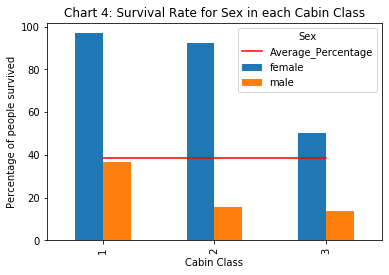

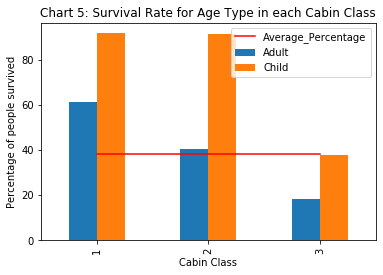

In [35]:
# Creating dataframe for average value
pclass_average = pd.DataFrame({
        pclass_surv.index.name : pclass_surv.index.tolist(),
        'Average_Percentage': [percentage_passengers_survived]*len(pclass_surv),
        })

# Creating bar plot for pclass and gender combined data 

plot_count += 1

pcl_gen_surv = pclass_gender_surv.unstack(-1)
xlabels = ['Cabin Class', 'Sex']
plt.figure()
ax = pclass_average.plot(y = 'Average_Percentage', kind = 'line', color = 'r')
pcl_gen_surv.plot(kind = 'bar', ax = ax)
plt.xlabel(xlabels[0])
plt.ylabel('Percentage of people survived')
plt.title ('Chart %s: Survival Rate for %s in each %s' % (plot_count, xlabels[1],xlabels[0]))


# Creating dataframe from pclass and age combined data with age_types as column names
pclass_age_surv_df = pd.DataFrame({
        'Pclass' : list(set(pclass_age_surv['Pclass'])),
        'Adult' : pclass_age_surv[pclass_age_surv['Age_Type'] == 'Adult']['Survival_Percentage'].values,
        'Child' : pclass_age_surv[pclass_age_surv['Age_Type'] == 'Child']['Survival_Percentage'].values,
        })

plot_count += 1

ax2 = pclass_average.plot(y = 'Average_Percentage', kind = 'line', color = 'r')
pclass_age_surv_df.plot(x = 'Pclass', kind = 'bar', ax = ax2)
plt.xlabel('Cabin Class')
plt.ylabel('Percentage of people survived')
plt.title ('Chart %s: Survival Rate for %s in each %s' % (plot_count, 'Age Type','Cabin Class'))




The results from these charts look largely consistent with those seen from Charts 1, 2 and 3. 
Looking at Chart 4, I see that females had a much higher survival rate than males in all the cabin classes. The survival rate for females is consistently higher than the ship's average whereas the survival rate for males remains consistently lower. However, there are some interesting observations. The males surivival rate for 1st Class is only slightly lower than the ship's average which wasn't obvious from the results illustrated in Chart 2. In addition, I see that the survival rate for both females and males reduces as we go from 1st Class to 2nd Class and to 3rd Class. This shows that the reduction in survival rate across Cabin Classes as seen in Chart 1 wasn't particularly due to survival rate change across a particular sex. Another observation is that though, the survival rate in 3rd Class is lower than the ship's average, the female survival rate in this Class is still higher than that average. 
The observations from Charts 1, 2 and 4 seem to suggest that females had a higher chance of survival than males in the Titanic accident. 

Chart 5 shows the children had a much higher survival rate than adults in all the cabin classes. I can make some interesting observations here. The children had almost the same survival rate in 1st and 2nd Classes and higher than ships's average. This hasn't been observed for either males, females or adults through any of the above analysis. The survival rate for children drops significantly in 3rd Class and is even lower than the ship's average. I also see that survival rate for adults drops as we go from 1st Class to 2nd Class and then to 3rd Class. Their survival rate in 1st and 2nd Class is higher than ship's average but it is quite below the average in the 3rd Class.

The above charts give interesting observations and give an insight into how the Cabin Class, gender and age had an impact on the chances of survival in this particular accident. At the same time, they also raise some more questions which I will discuss below.

The population on the ship can be broken into 4 parts - Adult Male, Adult Female, Child Male and Child Female. These can be further broken into 3 parts each depending on the Cabin Class but for the moment, let us stick with the 4 breakdowns only. In all cabin classes, we notice the below results for survival rates:

Females (Adult and Child) have higher survival rate than Males (Adult and Child).
Children (Females and Males) have higher survival rate than Adults (Females and Males). 

I observe that female children are consistently in the higher survival rate group and adult males in the lower survival rate group. The same cannot be said about female adults and male children. I wonder how the survival rates for each of the 4 passenger types stack up in each Cabin Class. I will next do this analysis.

In [36]:
# I will filter the passengers_orig dataframe that has the data about all passengers into either adult or child
# and then calculate the percentage survival using the same method as used before 
# I will use the same function (get_survival_percentage) but will feed the filtered passenger list

passengers_child = passengers_orig[passengers_orig['IsChild'] == True]

pclass_gender_child_surv = get_survival_percentage(['Pclass','Sex'], passengers_child)
print ("\nSurvival rate by pclass and gender for children: \n", pclass_gender_child_surv)

passengers_adult = passengers_orig[passengers_orig['IsAdult'] == True]

pclass_gender_adult_surv = get_survival_percentage(['Pclass','Sex'], passengers_adult)
print ("\nSurvival rate by pclass and gender for adults: \n", pclass_gender_adult_surv)





Survival rate by pclass and gender for children: 
 Pclass  Sex   
1       female     87.500000
        male      100.000000
2       female    100.000000
        male       81.818182
3       female     54.285714
        male       25.531915
dtype: float64

Survival rate by pclass and gender for adults: 
 Pclass  Sex   
1       female    97.647059
        male      34.745763
2       female    90.322581
        male       8.247423
3       female    44.736842
        male      11.666667
dtype: float64


In [37]:
# Unstack the above 2 outputs by -1.

pcl_gen_for_child = pclass_gender_child_surv.unstack(-1)
pcl_gen_for_adult = pclass_gender_adult_surv.unstack(-1)

#Output them both

print (pcl_gen_for_child)
print (pcl_gen_for_adult)


Sex         female        male
Pclass                        
1        87.500000  100.000000
2       100.000000   81.818182
3        54.285714   25.531915
Sex        female       male
Pclass                      
1       97.647059  34.745763
2       90.322581   8.247423
3       44.736842  11.666667


In [38]:
# Update column names to reflect adult or child

pcl_gen_for_child.columns = ['female child', 'male child']
pcl_gen_for_adult.columns = ['female adult', 'male adult']

# Print both again

print (pcl_gen_for_child)
print (pcl_gen_for_adult)

        female child  male child
Pclass                          
1          87.500000  100.000000
2         100.000000   81.818182
3          54.285714   25.531915
        female adult  male adult
Pclass                          
1          97.647059   34.745763
2          90.322581    8.247423
3          44.736842   11.666667


In [39]:
# Confirmed that the names are correctly changed. Combining the 2 data tables into one 
pcl_gen_all_age = pcl_gen_for_child.copy()
pcl_gen_all_age['female adult'] = pcl_gen_for_adult['female adult']
pcl_gen_all_age['male adult'] = pcl_gen_for_adult['male adult']

pcl_gen_all_age

,female child,male child,female adult,male adult
Pclass,,,,
1,87.500000,100.000000,97.647059,34.745763
2,100.000000,81.818182,90.322581,8.247423
3,54.285714,25.531915,44.736842,11.666667


Text(0.5, 1.0, 'Chart 6: Survival Rate for Female Adult, Female Child, Male Adult, Male Child in each Cabin Class')

<Figure size 432x288 with 0 Axes>

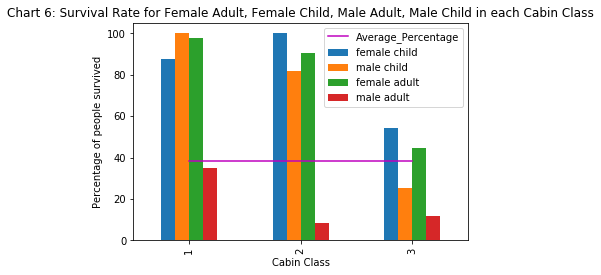

In [40]:
# Plotting pcl_gen_all_age

plot_count += 1

plt.figure()
ax = pclass_average.plot(y = 'Average_Percentage', kind = 'line', color = 'm')
pcl_gen_all_age.plot(kind = 'bar', ax = ax)


passenger_type  = 'Female Adult, Female Child, Male Adult, Male Child'
plt.xlabel('Cabin Class')
plt.ylabel('Percentage of people survived')
plt.title ('Chart %s: Survival Rate for %s in each %s' % (plot_count, passenger_type ,'Cabin Class'))


Chart 6 shows that in Cabin Classes 1st and 2nd, female child, female adults (all females) and male child have a very high rate of survival and is much above the ship's average, whereas in Cabin Class 3rd, their survival rate drops and is around the ship's average. On the other hand, adult males have extremely low rates of survival in Cabin Class 2nd and 3rd but just below the ship's average in 1st Cabin. This shows that being a female or an adult child certainly helped in improving the survival rate on Titanic if staying in 1st or 2nd Cabin Classes. In addition, adult males had a very low survival rate. I will try to analyse if there is any further relationship between males and females through scatter plot with the data used in Chart 6.

In [41]:

# Creating new dataframe which combines pcl_gen_for_child and pcl_gen_for_adult
# This dataframe will have columns pclass, age, Male Survival Percentage and Female Survival Percentage. 
#I will create an array for each group

# pcl_gen_for_child

pcl_values = pcl_gen_for_child.index.tolist()
pcl_size = len(pcl_values)
age_values = ['child'] * pcl_size
female_values = list(pcl_gen_for_child['female child'])
male_values = list(pcl_gen_for_child['male child'])

pcl_col = pcl_values
age_col = age_values
female_col = female_values
male_col = male_values

# pcl_gen_for_adult

pcl_values = pcl_gen_for_adult.index.tolist()
pcl_size = len(pcl_values)
age_values = ['adult'] * pcl_size
female_values = list(pcl_gen_for_adult['female adult'])
male_values = list(pcl_gen_for_adult['male adult'])

pcl_col = pcl_col + pcl_values
age_col = age_col + age_values
female_col = female_col + female_values
male_col = male_col + male_values

  
new_surv_df = pd.DataFrame({
        'Cabin Class': pcl_col,
        'Age': age_col,
        'Female Survival Percentage': female_col,
        'Male Survival Percentage': male_col 
    })

new_surv_df.head(15)


,Cabin Class,Age,Female Survival Percentage,Male Survival Percentage
0,1,child,87.500000,100.000000
1,2,child,100.000000,81.818182
2,3,child,54.285714,25.531915
3,1,adult,97.647059,34.745763
4,2,adult,90.322581,8.247423
5,3,adult,44.736842,11.666667


Text(0.5, 0.98, 'Chart 7: Comparison of Female vs Male Survival Percentages split by Age and Cabin Class.')

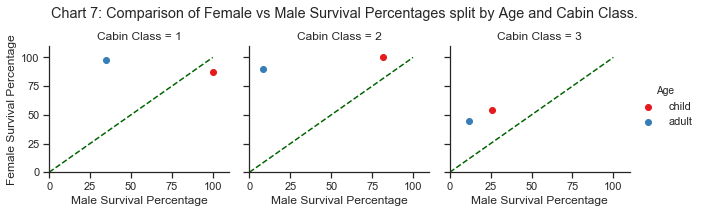

In [42]:
# Plotting multiple axes scatter plot

plot_count += 1
sns.set(style = 'ticks', color_codes=True)
g = sns.FacetGrid(new_surv_df, col = 'Cabin Class', hue = 'Age', palette = 'Set1', col_order = [1, 2, 3])
g = (g.map(plt.scatter, 'Male Survival Percentage', 'Female Survival Percentage')
     .add_legend()
    .set(xlim = (0,110), ylim = (0,110)))

for ax in g.axes.flat:
    ax.plot((0,100), (0,100), color = 'DarkGreen', ls = '--')

plt.subplots_adjust(top = 0.8)
g.fig.suptitle('Chart %s: Comparison of Female vs Male Survival Percentages split by Age and Cabin Class.' % (plot_count))


In Chart 7, the dark green dotted line represents the Equal Survival Rate, that is, all points on it represent equal survival percentage for males and females. This line can be used for comparison purposes as all points above this line mean that Female survival rate is higher than that for males and vice versa. The chart shows that generally females had a better survival rate than males in all cabins and age groups. I am able to observe this as the dots are all above the line, except one.  The one exception dot is only marginal and from visual inspection, doesn't look significantly far from the line.

With all the analysis done, I will now move to the next stage to give conclusions

Conclusions Phase:

I have data from one ship accident only and hence, it is not possible to draw any statistical interpretations. Hence, the results are an analysis of what happened during the Titanic accident and should not be used to draw any inferences for future accidents. 
The analysis has been limited due to constraints such as missing data. I have made assumptions where I could and these are summarised here:

1. I have assumed that anyone of the age of 18 and above is an adult and those with age less than 18 are children. The age level of 18 has been assumed based on the current understanding of adulthood in several societies and may not precisely reflect the accepted adult starting age at the time of the accident

2. I calculated that 177 passengers out of a total of 891 passengers on ship did not have their age information. This is 19.87% of the passengers and so I believe it represents a significant portion of the data. Ignoring these passengers can result in skewed analysis and incorrect results.

3. I used a technique of classifying these 177 passengers as adults or children based on their titles (Mr, Mrs,...). I created 3 different assumptions (mentioned as hypothesis) in Inconsistency 2 analysis under Data Wrangling section. I tested them against the other passengers whose passenger information was available and based on the results, applied them to these 177 passengers. As a result, I was able to add information for adult or child to 141 passengers but this meant that based on the error rate from the testing, roughly 0.85% of the total passenger data has an incorrect adult/child flag. The 0.85% number could vary in reality but it represented a small error rate compared to the inclusion of a significant number of passengers in the analysis.

4. There still remained 36 passengers (4.04% of the entire passenger data set) who had the title of "Miss" that could not be assigned the adult / child flag and so these passengers were filtered out while doing the analysis for age. This should be kept in mind while making the conclusions.

5. I also ran another analysis (Inconsistency 3 in Data Wrangling Section) to check if the number of parents, children, siblings and spouse mentioned for each individual was actually present in the data set, that is, whether all the expected family members on board are present in the data. This was done to ensure that I have the complete data or identify the missing number of passengers. From the analysis, I realised that several family members seemed missing. The data had 1 combined value for parents and children and another for siblings and spouse. In addition, my analysis was based on surnames (or maiden surname as well for married females) which meant that people from different families but same surname would get identified as being from same family in my analysis. As a result, I wasn't able to identify which family member was missing and was only able to calculate the minimum number of missing family members. There is also a potential that entire families are missing from the data set and so I am unable to identify them as missing. From the available data, I calculated that a minimum of 33 passengers are not included in this data. This represents 3.57% of the present passengers. Breaking this down to each Pclass, minimum percentage of missing passengers are 4% for 1st Class, 4.66% for 2nd Class and 2.96% for 3rd Class.

I have made the below conclusions from the analysis:
   
1. The percentage of survivors is highest in 1st Class, relatively lower in 2nd Class and lowest in 3rd Class. The percentage for 1st Class and 2nd Class is higher than the average for the entire ship.

2. Females had a much higher rate of survival compared to males. While the survival rate for females is much higher to the ship's average, the survival rate for males is much lower than the ship's average

3. Children had a higher rate of survival than adults. Morevoer, children had a survival rate higher than the ship's average but adults had a lower survival rate than the ship's average

4. Breaking the data further down, I realise that female adults, female children and male children had a very high survival rate for Cabin Classes 1st and 2nd, but this rate was around the ship's average for Cabin Class 3. The male adults had extremely low rates of survival in Cabin Class 2 and 3 and just under the ship's average for Cabin Class 1.

Combining the information above, I conclude that the Cabin Class had an impact on the chances of survival. Cabin class 3 had average to low chances of survival for all age groups and sexes. Cabin Class 1 and 2 had high chance of survival but only for females adults and all children. The male adults had a low chance of survival in this accident as their survival rate across all Cabin classes is fairly below average, and only slightly under average for Cabin Class 1. 



Citations:
I would like to cite the below websites for providing documentations, worked examples and worked solutions to real problems (raised by other people) as this helped in learning new syntax for writing the code for this Project.

http://pandas.pydata.org/pandas-docs/stable/groupby.html

http://pandas.pydata.org/pandas-docs/stable/indexing.html

http://pandas.pydata.org/pandas-docs/stable/groupby.html

http://www.tutorialspoint.com/python/string_index.htm

http://matplotlib.org/api/artist_api.html#matplotlib.artist.Artist.set_rasterized

http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.plot.html#pandas.DataFrame.plot

http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html

http://matplotlib.org/api/colors_api.html

http://stackoverflow.com

https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.FacetGrid.html#seaborn.FacetGrid

http://stanford.edu/~mwaskom/software/seaborn/tutorial/axis_grids.html
